In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_csv("babies.csv").drop("case", axis = 1)

X.isna().sum()

bwt           0
gestation    13
parity        0
age           2
height       22
weight       36
smoke        10
dtype: int64

In [153]:
#There are few na, lets drop them
X = X.dropna(axis = 0)

X.describe()# we have no outliers 

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [154]:
y = X.pop("bwt")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), X_train.columns)])

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())
                             ])

In [156]:
from sklearn.metrics import mean_absolute_error as mae
my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_test)

print(f"baseline linreg MAE: {mae(y_test, preds)}")

baseline linreg MAE: 12.545006820154121


In [157]:
coefs = my_pipeline["model"].coef_

list(zip(coefs, X_train.columns)) #It shows quite predictable results. Lets use Lasso to do some feature selection 

[(6.795404182355275, 'gestation'),
 (-1.2696290959026348, 'parity'),
 (-0.015498275629056714, 'age'),
 (3.1919802518950626, 'height'),
 (0.966205333468521, 'weight'),
 (-4.456412712578199, 'smoke')]

In [158]:
from sklearn.linear_model import Lasso

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), X_train.columns)])

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', Lasso(alpha=0.2))
                             ])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_test)

print(f"baseline Lasso MAE: {mae(y_test, preds)}")

baseline Lasso MAE: 12.542180526296706


In [159]:
coefs = my_pipeline["model"].coef_
list(zip(coefs, X_train.columns))

[(6.609799018160174, 'gestation'),
 (-1.0538859481659446, 'parity'),
 (0.0, 'age'),
 (3.042701953852974, 'height'),
 (0.8752954592502337, 'weight'),
 (-4.277981957230473, 'smoke')]

In [160]:
#Thus we can drop age column

preprocessor = ColumnTransformer(
    transformers=[('droout', "drop", ["age"]), ('num', StandardScaler(), X_train.columns)])

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())
                             ])
my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_test)

print(f"MAE: {mae(y_test, preds)}") # didnt improve 

MAE: 12.545006820154121


In [161]:
#Lets use smth more complicated: ffn
X_ = X_train.copy()
y_ = y_train.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, train_size = 0.8)

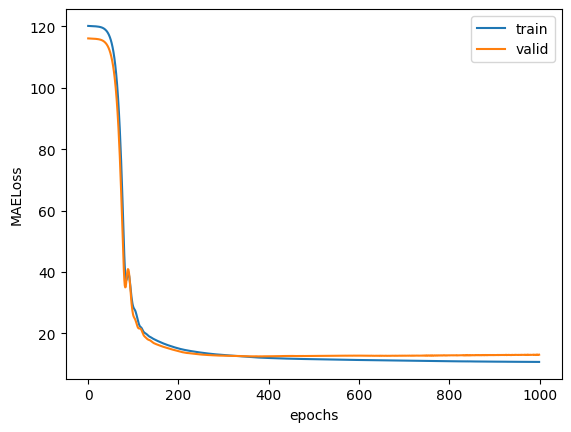

In [170]:
import torch
import torch.nn as nn
from torch.nn import L1Loss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

class FeedForwardNN(nn.Module):
  def __init__(self, in_features, out_features = 1,  hiden_layer = 32):
    super().__init__()
    self.ffn = nn.Sequential(nn.Linear(in_features, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(), 
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, out_features))
  def forward(self,x):
    return self.ffn(x).squeeze()

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), X_train.columns)])
X_train_tens = torch.tensor(preprocessor.fit_transform(X_train)).float()
y_train_tens = torch.tensor(y_train.values).float()
X_valid_tens = torch.tensor(preprocessor.transform(X_valid)).float()
y_valid_tens = torch.tensor(y_valid.values).float()


model = FeedForwardNN(in_features = X_train_tens.shape[1])
optimizer = Adam(model.parameters(), lr = 0.001)
loss_fn = L1Loss()

train_stats = []
valid_stats = []
epochs = []

for epoch in range(1000):

  model.train()
  optimizer.zero_grad()
  loss = loss_fn(model(X_train_tens), y_train_tens)
  loss.backward()
  optimizer.step()
  train_stats.append(loss.item())
    
  model.eval()
  with torch.no_grad():
    loss = loss_fn(model(X_valid_tens), y_valid_tens)
    valid_stats.append(loss.item())
  epochs.append(epoch)

plt.plot(epochs, train_stats, label="train")
plt.plot(epochs, valid_stats, label="valid")
plt.xlabel("epochs")
plt.ylabel("MAELoss")
plt.legend()
plt.show()

In [171]:
preds = model(torch.tensor(preprocessor.transform(X_test)).float()).detach().numpy()

print(f"FFN MAE: {mae(y_test, preds)}") # give small but no significance upgrade

FFN MAE: 12.678756713867188


In [172]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose = 0)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(f"FFN MAE: {mae(y_test, preds)}") # perfoms poor

FFN MAE: 13.009149206834502
